##### Copyright 2023 The TF-Agents Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# DQN C51/Rainbow

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/agents/tutorials/9_c51_tutorial">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/9_c51_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/docs/tutorials/9_c51_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/agents/docs/tutorials/9_c51_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction

This example shows how to train a [Categorical DQN (C51)](https://arxiv.org/pdf/1707.06887.pdf) agent on the Cartpole environment using the TF-Agents library.

![Cartpole environment](https://github.com/tensorflow/agents/blob/master/docs/tutorials/images/cartpole.png?raw=1)

Make sure you take a look through the [DQN tutorial](https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb) as a prerequisite. This tutorial will assume familiarity with the DQN tutorial; it will mainly focus on the differences between DQN and C51.


## Setup


If you haven't installed tf-agents yet, run:

In [2]:
!sudo apt-get update
#!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
#!pip install 'imageio==2.4.0'
#!pip install pyvirtualdisplay
!pip install tf-agents
!pip install pyglet

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]      
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,014 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [996 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,283 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,260 kB]
Fetched 4,890 kB in 4s (1,093 kB/s)                        
Reading package lists... Done


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
#import PIL.Image
#import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from envs.trading_env_ext import TradingEnv
from utils import load_dataset

# Set up a virtual display for rendering OpenAI gym environments.
#display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

2023-09-21 03:08:19.183065: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 03:08:20.183206: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 03:08:20.186514: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 03:08:23.670795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Hyperparameters

In [4]:
env_name = "TradingEnv-v1" # @param {type:"string"}
num_iterations = 30000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 3  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (100,)

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 1000  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 6000  # @param {type:"integer"}

WINDOW_SIZE=10

## Environment

Load the environment as before, with one for training and one for evaluation. Here we use CartPole-v1 (vs. CartPole-v0 in the DQN tutorial), which has a larger max reward of 500 rather than 200.

In [5]:
df = load_dataset('./KO.csv')
train_py_env = TradingEnv(df=df, window_size=WINDOW_SIZE, frame_bound=(WINDOW_SIZE, 1500))
eval_py_env = TradingEnv(df=df, window_size=WINDOW_SIZE, frame_bound=(1600, 2500))

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:335: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == -np.inf] = low
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:336: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == np.inf] = high
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:338: RuntimeWarning: invalid value encountered in cast
  self._maximum[self._maximum == -np.inf] = low
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:339: RuntimeWarning: invalid value encountered in cast
  self._maximum[self._maximum == np.inf] = high
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:335: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == -np.inf] = low
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:336: RuntimeWarning: invalid value encountered in cast
  self._mi

## Agent

C51 is a Q-learning algorithm based on DQN. Like DQN, it can be used on any environment with a discrete action space.

The main difference between C51 and DQN is that rather than simply predicting the Q-value for each state-action pair, C51 predicts a histogram model for the probability distribution of the Q-value:

![Example C51 Distribution](images/c51_distribution.png)

By learning the distribution rather than simply the expected value, the algorithm is able to stay more stable during training, leading to improved final performance. This is particularly true in situations with bimodal or even multimodal value distributions, where a single average does not provide an accurate picture.

In order to train on probability distributions rather than on values, C51 must perform some complex distributional computations in order to calculate its loss function. But don't worry, all of this is taken care of for you in TF-Agents!

To create a C51 Agent, we first need to create a `CategoricalQNetwork`. The API of the `CategoricalQNetwork` is the same as that of the `QNetwork`, except that there is an additional argument `num_atoms`. This represents the number of support points in our probability distribution estimates. (The above image includes 10 support points, each represented by a vertical blue bar.) As you can tell from the name, the default number of atoms is 51.


In [6]:
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

We also need an `optimizer` to train the network we just created, and a `train_step_counter` variable to keep track of how many times the network was updated.

Note that one other significant difference from vanilla `DqnAgent` is that we now need to specify `min_q_value` and `max_q_value` as arguments. These specify the most extreme values of the support (in other words, the most extreme of the 51 atoms on either side). Make sure to choose these appropriately for your particular environment. Here we use -20 and 20.

In [7]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

One last thing to note is that we also added an argument to use n-step updates with $n$ = 2. In single-step Q-learning ($n$ = 1), we only compute the error between the Q-values at the current time step and the next time step using the single-step return (based on the Bellman optimality equation). The single-step return is defined as:

$G_t = R_{t + 1} + \gamma V(s_{t + 1})$

where we define $V(s) = \max_a{Q(s, a)}$.

N-step updates involve expanding the standard single-step return function $n$ times:

$G_t^n = R_{t + 1} + \gamma R_{t + 2} + \gamma^2 R_{t + 3} + \dots + \gamma^n V(s_{t + n})$

N-step updates enable the agent to bootstrap from further in the future, and with the right value of $n$, this often leads to faster learning.

Although C51 and n-step updates are often combined with prioritized replay to form the core of the [Rainbow agent](https://arxiv.org/pdf/1710.02298.pdf), we saw no measurable improvement from implementing prioritized replay. Moreover, we find that when combining our C51 agent with n-step updates alone, our agent performs as well as other Rainbow agents on the sample of Atari environments we've tested.

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes. We can compute the average return metric as follows.


In [8]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

compute_avg_return(eval_env, random_policy, num_eval_episodes)

# Please also see the metrics module for standard implementations of different
# metrics.

-20.95511

## Data Collection

As in the DQN tutorial, set up the replay buffer and the initial data collection with the random policy.

In [9]:
#@test {"skip": true}
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

def collect_step(environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
  collect_step(train_env, random_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


## Training the agent

The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

The following will take ~7 minutes to run.

In [10]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 1000: loss = 3.3764431476593018
step = 2000: loss = 3.197866439819336
step = 3000: loss = 3.3496391773223877
step = 4000: loss = 3.4284582138061523
step = 5000: loss = 3.5709571838378906
step = 6000: loss = 3.4235787391662598
step = 6000: Average Return = -135.73
step = 7000: loss = 3.479243278503418
step = 8000: loss = 3.419482707977295
step = 9000: loss = 3.675220489501953
step = 10000: loss = 3.4801928997039795
step = 11000: loss = 3.394324779510498
step = 12000: loss = 3.5084235668182373
step = 12000: Average Return = -234.26
step = 13000: loss = 3.5614004135131836
step = 14000: loss = 3.2543439865112305
step = 15000: loss = 3.4720287322998047
step = 16000: loss = 3.536860942840576
step = 17000: loss = 3.480327606201172
step = 18000: loss = 3.46

## Visualization


### Plots

We can plot return vs global steps to see the performance of our agent. In `Cartpole-v1`, the environment gives a reward of +1 for every time step the pole stays up, and since the maximum number of steps is 500, the maximum possible return is also 500.

(-249.96368637084962, 100.0)

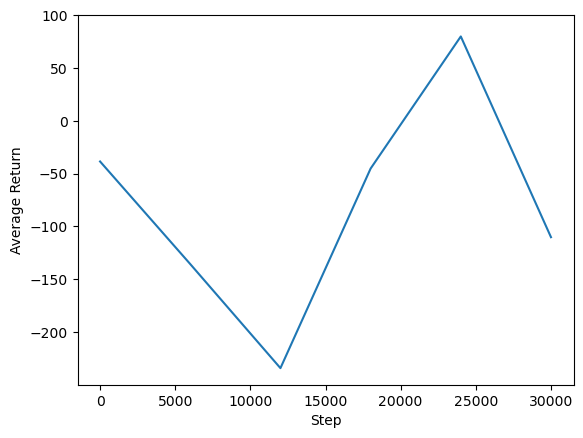

In [14]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=100)

### Videos

It is helpful to visualize the performance of an agent by rendering the environment at each step. Before we do that, let us first create a function to embed videos in this colab.

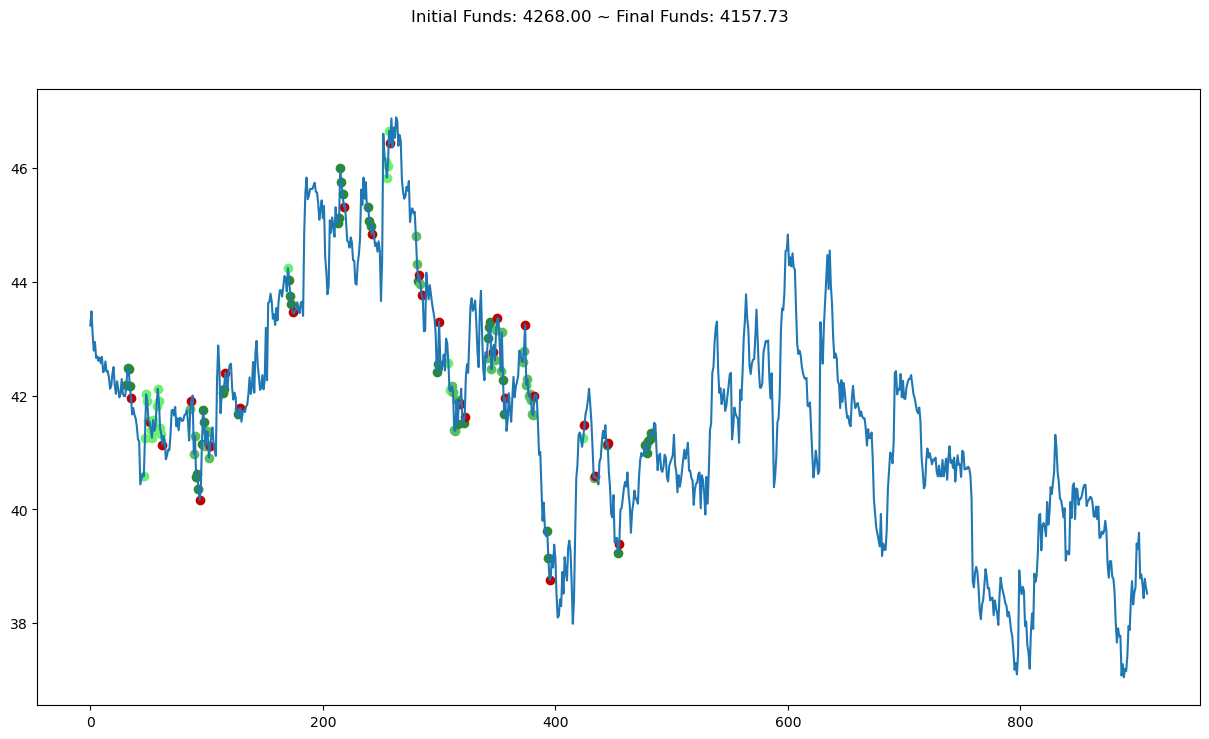

<Figure size 640x480 with 0 Axes>

In [12]:

def render_policy_eval(policy, filename):
    time_step = eval_env.reset()
    while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
    eval_py_env.render('human')
    plt.savefig(filename)

render_policy_eval(agent.policy, "trained-agent")

The following code visualizes the agent's policy for a few episodes:

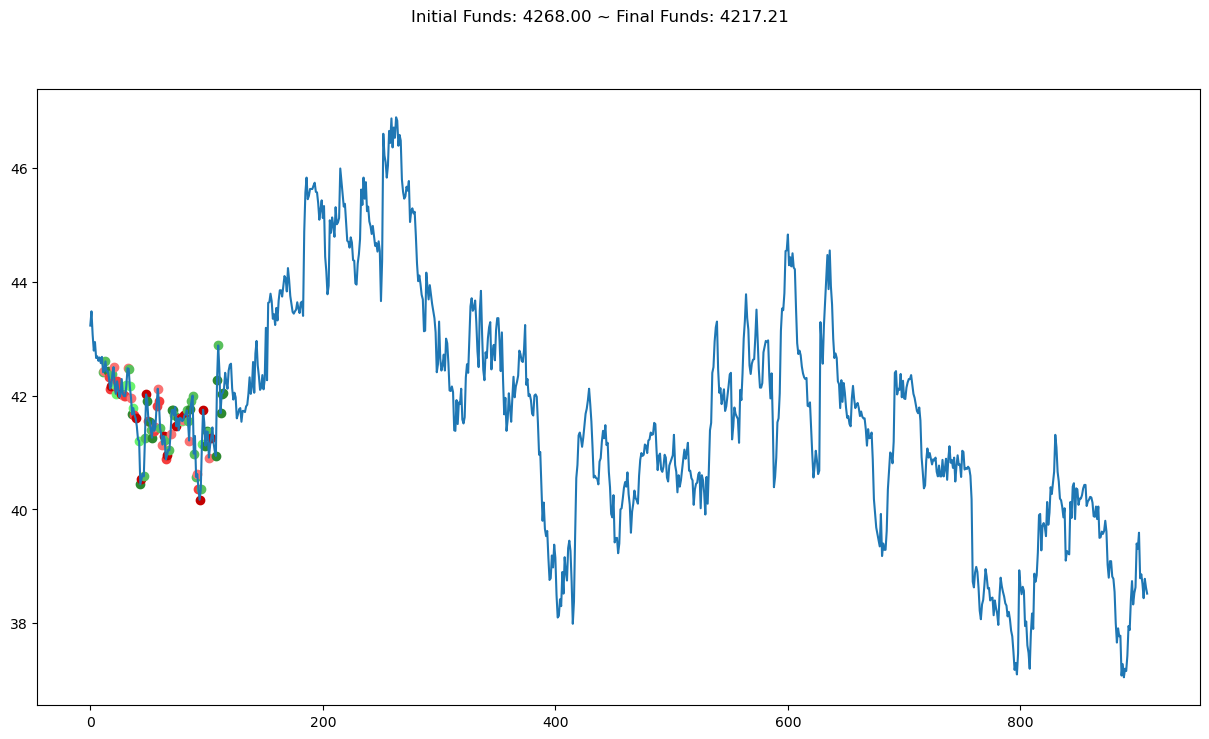

<Figure size 640x480 with 0 Axes>

In [13]:
render_policy_eval(random_policy, "random-agent")

C51 tends to do slightly better than DQN on CartPole-v1, but the difference between the two agents becomes more and more significant in increasingly complex environments. For example, on the full Atari 2600 benchmark, C51 demonstrates a mean score improvement of 126% over DQN after normalizing with respect to a random agent. Additional improvements can be gained by including n-step updates.

For a deeper dive into the C51 algorithm, see [A Distributional Perspective on Reinforcement Learning (2017)](https://arxiv.org/pdf/1707.06887.pdf).